# Mental Health Crisis Detection from Social Media

## Overview
This project focuses on detecting indicators of mental health crises through user-generated content on social media platforms. With increasing online engagement, early identification of concerning patterns in social media posts can provide valuable insights for mental health interventions.

## Objective
The goal is to construct a clean and unified dataset by preprocessing and merging multiple sources, which will serve as input for further natural language processing and machine learning tasks related to emotion and sentiment classification.

## Datasets
- **Mental-Health-Twitter.csv**: Annotated tweets from users with reported mental health concerns.
- **reddit_depression_suicidewatch.csv**: Reddit posts from forums such as r/depression and r/SuicideWatch.
- **go_emotions_dataset.csv**: A multi-label emotion classification dataset collected from Reddit.

## Pipeline
1. Load datasets from various sources.
2. Extract relevant information and unify schema.
3. Clean and filter text data.
4. Export the final cleaned dataset for downstream modeling.

In [ ]:
import pandas as pd

# Define file paths
go_path     = 'datasets/go_emotions_dataset.csv'
twitter_path= 'datasets/Mental-Health-Twitter.csv'
reddit_path = 'datasets/reddit_depression_suicidewatch.csv'

# Load raw DataFrames
go_raw      = pd.read_csv(go_path)
twitter_raw = pd.read_csv(twitter_path)
reddit_raw  = pd.read_csv(reddit_path)

# ——— GoEmotions processing ———
# Drop “very unclear” examples
go_clean = go_raw[~go_raw['example_very_unclear']].copy()

# Identify one‐hot emotion columns
emotion_cols = [c for c in go_clean.columns
                if c not in ('id', 'text', 'example_very_unclear')]

# Build a (id, text, label) DataFrame:
# label = the emotion whose column == 1; if no 1’s, label=None
def pick_emotion(row):
    vals = row.values
    if vals.sum() == 0:
        return None
    return emotion_cols[vals.argmax()]

go_emotions = go_clean[['id','text']].copy()
go_emotions['label'] = go_clean[emotion_cols].apply(pick_emotion, axis=1)

# Quick check
print("GoEmotions:", go_emotions.shape)
print(go_emotions['label'].value_counts().head(10))
print(go_emotions.head())


GoEmotions: (207814, 3)
label
neutral           55298
admiration        17131
approval          15530
annoyance         11929
disapproval        8917
amusement          8862
gratitude          8437
anger              7956
curiosity          7707
disappointment     6769
Name: count, dtype: int64
        id                                               text      label
0  eew5j0j                                    That game hurt.    sadness
2  ed2mah1     You do right, if you don't care then fuck 'em!    neutral
3  eeibobj                                 Man I love reddit.       love
4  eda6yn6  [NAME] was nowhere near them, he was by the Fa...    neutral
5  eespn2i  Right? Considering it’s such an important docu...  gratitude


### Label Transformation and Column Formatting

This section prepares the Twitter and Reddit datasets for further processing:

- The Twitter dataset is reformatted by renaming columns to a standard schema and mapping numeric labels (`1`, `0`) to descriptive class labels (`'depression'`, `'control'`).
- The Reddit dataset is assigned unique post identifiers based on row indices to ensure compatibility during concatenation.
- Both datasets are then subset to include only the `id`, `text`, and `label` columns.

Basic dataset statistics and sample rows are printed to verify the transformations.

In [2]:
# Twitter: rename columns and map numeric labels to strings
twitter = twitter_raw.rename(
    columns={'post_id': 'id', 'post_text': 'text'}
)[['id', 'text', 'label']].copy()

# Map 1→'depression', 0→'control'
twitter['label'] = twitter['label'].map({1: 'depression', 0: 'control'})

# Reddit: generate unique IDs and keep only id, text, label
reddit = reddit_raw.copy()
reddit['id'] = reddit.index.map(lambda i: f'reddit_{i}')
reddit = reddit[['id', 'text', 'label']]

# Quick checks
print("Twitter:", twitter.shape)
print(twitter['label'].value_counts(), "\n")
print("Sample Twitter rows:")
print(twitter.head(), "\n")

print("Reddit:", reddit.shape)
print(reddit['label'].value_counts(), "\n")
print("Sample Reddit rows:")
print(reddit.head())


Twitter: (20000, 3)
label
depression    10000
control       10000
Name: count, dtype: int64 

Sample Twitter rows:
                   id                                               text  \
0  637894677824413696  It's just over 2 years since I was diagnosed w...   
1  637890384576778240  It's Sunday, I need a break, so I'm planning t...   
2  637749345908051968  Awake but tired. I need to sleep but my brain ...   
3  637696421077123073  RT @SewHQ: #Retro bears make perfect gifts and...   
4  637696327485366272  It’s hard to say whether packing lists are mak...   

        label  
0  depression  
1  depression  
2  depression  
3  depression  
4  depression   

Reddit: (20363, 3)
label
depression      10371
SuicideWatch     9992
Name: count, dtype: int64 

Sample Reddit rows:
         id                                               text         label
0  reddit_0  I recently went through a breakup and she said...    depression
1  reddit_1  I do not know how to navigate these feelings, 

### Dataset Merging

The three standardized datasets — GoEmotions, Twitter, and Reddit — are vertically concatenated into a single DataFrame. All three datasets share the same schema: `id`, `text`, and `label`, enabling seamless integration.

The resulting merged dataset serves as the consolidated input for further processing and analysis.

In [3]:
# Concatenate all three sources into merged_df

#    go_emotions (id, text, label)
#    twitter     (id, text, label)
#    reddit      (id, text, label)

# Concatenate
merged_df = pd.concat(
    [go_emotions, twitter, reddit],
    axis=0,
    ignore_index=True
)


### Data Cleaning and Final Merged Data Export

The merged dataset is further cleaned to ensure quality and consistency:

- Rows with missing `text` or `label` values are removed.
- Whitespace is stripped from text entries to standardize formatting.
- Duplicate text entries are dropped, retaining only the first occurrence to avoid redundancy.

The final cleaned dataset is then exported to a CSV file for downstream modeling and evaluation.

In [ ]:
# Clean merged_df and export

# Drop rows with missing text or label
merged_df_clean = merged_df.dropna(subset=['text', 'label']).copy()

# Strip leading/trailing whitespace in text
merged_df_clean['text'] = merged_df_clean['text'].str.strip()

# Remove exact duplicate texts (keep first occurrence)
merged_df_clean = merged_df_clean.drop_duplicates(subset=['text'])

# Save cleaned DataFrame to CSV
output_path = 'datasets/merged_dataset_clean.csv'
merged_df_clean.to_csv(output_path, index=False)

# Sanity-check
print("Cleaned shape:", merged_df_clean.shape)
print(f"Saved cleaned dataset to: {output_path}")

Cleaned shape: (97563, 3)
Saved cleaned dataset to: /kaggle/working/merged_dataset_clean.csv


### Spark Session Initialization

A Spark session is initiated to enable distributed data processing. This environment is useful for handling large-scale datasets efficiently. The application is named for identification, and the log level is set to "ERROR" to reduce verbosity during execution.

In [5]:
# Start Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CustomSentiment") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 05:27:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load Cleaned Dataset into Spark

The cleaned dataset is read into a Spark DataFrame from CSV format. Only the `text` and `label` columns are retained for analysis. The schema is automatically inferred, and basic inspection is performed to validate the data structure and content.

In [ ]:
# Read CSV, keep only text & label
df = spark.read.csv(
    "datasets/merged_dataset_clean.csv",
    header=True,
    inferSchema=True
).select("text", "label")

# Print schema & a few examples
df.printSchema()
df.show(5, truncate=False)

# Total row count
print("Total rows:", df.count())

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------+---------+
|text                                                                                                                                   |label    |
+---------------------------------------------------------------------------------------------------------------------------------------+---------+
|That game hurt.                                                                                                                        |sadness  |
|You do right, if you don't care then fuck 'em!                                                                                         |neutral  |
|Man I love reddit.                                                                                                                     |love     |
|[NAME] was nowhere near them, he

### Label Distribution Analysis

The distribution of examples across different labels is computed to assess class balance within the dataset. The results are ordered by frequency in descending order to highlight dominant classes.

In [7]:
# Display how many examples per label
df.groupBy("label") \
  .count() \
  .orderBy("count", ascending=False) \
  .show(truncate=False)

+--------------+-----+
|label         |count|
+--------------+-----+
|depression    |18894|
|neutral       |15707|
|SuicideWatch  |9229 |
|control       |8450 |
|admiration    |4856 |
|approval      |4286 |
|NULL          |3287 |
|annoyance     |3044 |
|amusement     |2540 |
|gratitude     |2521 |
|disapproval   |2434 |
|curiosity     |2217 |
|anger         |2191 |
|confusion     |1802 |
|disappointment|1711 |
|love          |1532 |
|joy           |1379 |
|optimism      |1367 |
|caring        |1353 |
|realization   |1335 |
+--------------+-----+
only showing top 20 rows



### Exploratory Data Analysis: Top 10 Label Frequencies

This section visualizes the distribution of the top 10 most frequent labels in the dataset. The Spark DataFrame is filtered to remove missing or empty labels, and the label counts are computed. The top labels are then converted to a pandas DataFrame and visualized using a bar chart to better understand class representation.

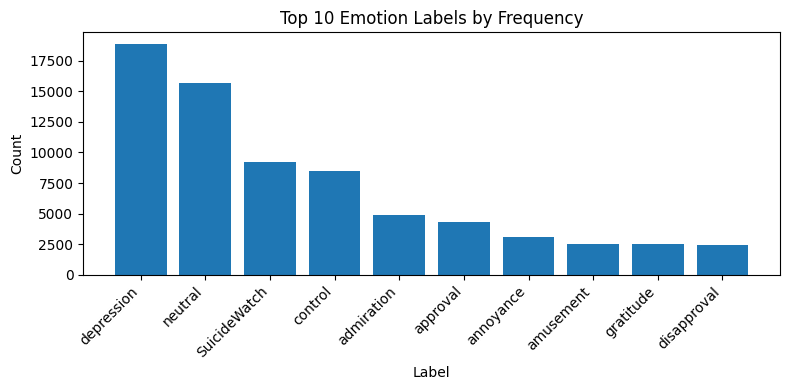

In [8]:
# EDA CELL: Top-10 Label Frequencies
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# (re‐define df2 in case this cell is run standalone)
df2 = df.filter(col("label").isNotNull() & (col("label") != ""))

# get top-10 labels
top10 = (
    df2.groupBy("label")
       .count()
       .orderBy(col("count").desc())
       .limit(10)
)

# convert to pandas for plotting
top10_pd = top10.toPandas()

# plot
plt.figure(figsize=(8,4))
plt.bar(top10_pd["label"], top10_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Top 10 Emotion Labels by Frequency")
plt.tight_layout()
plt.show()

### Label-Aware Downsampling

To address class imbalance, this step performs stratified downsampling. The threshold is set to the size of the fourth-largest class, and all labels with a higher count are proportionally downsampled to match this threshold. Less frequent classes are preserved in full. The result is a more balanced dataset that mitigates bias during model training.

In [9]:
from pyspark.sql.functions import col

# Drop actual null or empty labels
df2 = df.filter(col("label").isNotNull() & (col("label") != ""))

# Compute counts per label
counts = {row['label']: row['count']
          for row in df2.groupBy("label").count().collect()}

# Find the 4th-largest class size as our down-sample threshold
sorted_counts = sorted(counts.values(), reverse=True)
threshold = sorted_counts[3]
print("Down-sampling threshold (4th largest count):", threshold)

# Build sampling fractions: only shrink classes above the threshold
fractions = {
    label: (threshold / cnt if cnt > threshold else 1.0)
    for label, cnt in counts.items()
}

# Apply stratified sampling
df_sampled = df2.sampleBy("label", fractions, seed=42)

# Show the new top 20 label counts
print("New label distribution after downsampling:")
df_sampled.groupBy("label") \
          .count() \
          .orderBy("count", ascending=False) \
          .show(20, truncate=False)

Down-sampling threshold (4th largest count): 8450
New label distribution after downsampling:


+--------------+-----+
|label         |count|
+--------------+-----+
|depression    |8525 |
|neutral       |8508 |
|SuicideWatch  |8476 |
|control       |8450 |
|admiration    |4856 |
|approval      |4286 |
|annoyance     |3044 |
|amusement     |2540 |
|gratitude     |2521 |
|disapproval   |2434 |
|curiosity     |2217 |
|anger         |2191 |
|confusion     |1802 |
|disappointment|1711 |
|love          |1532 |
|joy           |1379 |
|optimism      |1367 |
|caring        |1353 |
|realization   |1335 |
|excitement    |1195 |
+--------------+-----+
only showing top 20 rows



### Exploratory Data Analysis: Average Text Length by Label

This analysis computes the average word count of posts for the top 10 most frequent labels. A new column for word count is derived by splitting the text on whitespace. The average length is calculated per label and visualized as a horizontal bar chart to examine variation in post verbosity across different categories.

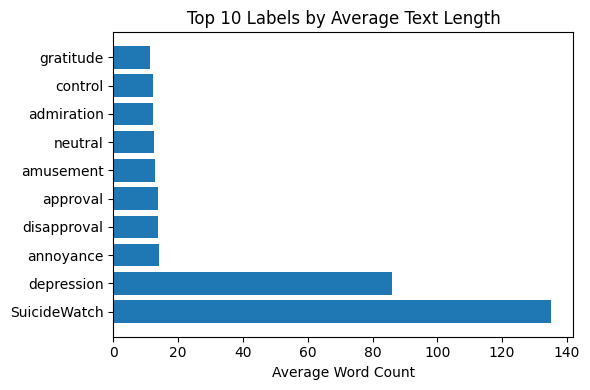

In [10]:
# EDA CELL: Average Text Length per Label (Top 10, Horizontal Bar)
from pyspark.sql.functions import split, size, col, avg, desc
import matplotlib.pyplot as plt

df2 = df.filter(col("label").isNotNull() & (col("label") != "")) \
        .withColumn("word_count", size(split(col("text"), "\\s+")))

# Pick the 10 most frequent labels
top10 = [r["label"] for r in
         df2.groupBy("label")
            .count()
            .orderBy(desc("count"))
            .limit(10)
            .collect()]

# Compute average word_count for those labels
avg_len_pd = (df2.filter(col("label").isin(top10))
                 .groupBy("label")
                 .agg(avg("word_count").alias("avg_wc"))
                 .orderBy("avg_wc", ascending=False)
                 .toPandas())

# Plot horizontal bar chart
plt.figure(figsize=(6,4))
plt.barh(avg_len_pd["label"], avg_len_pd["avg_wc"])
plt.xlabel("Average Word Count")
plt.title("Top 10 Labels by Average Text Length")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis: Top Tokens by Label

This section visualizes the most frequent non-stopword tokens for selected labels (`depression`, `neutral`, `SuicideWatch`, `control`). Text is preprocessed by removing punctuation, converting to lowercase, and splitting into tokens. Stopwords and empty strings are removed to focus on meaningful content. The top 10 tokens for each label are then displayed using horizontal bar charts in a 2x2 subplot layout, enabling comparative analysis across categories.

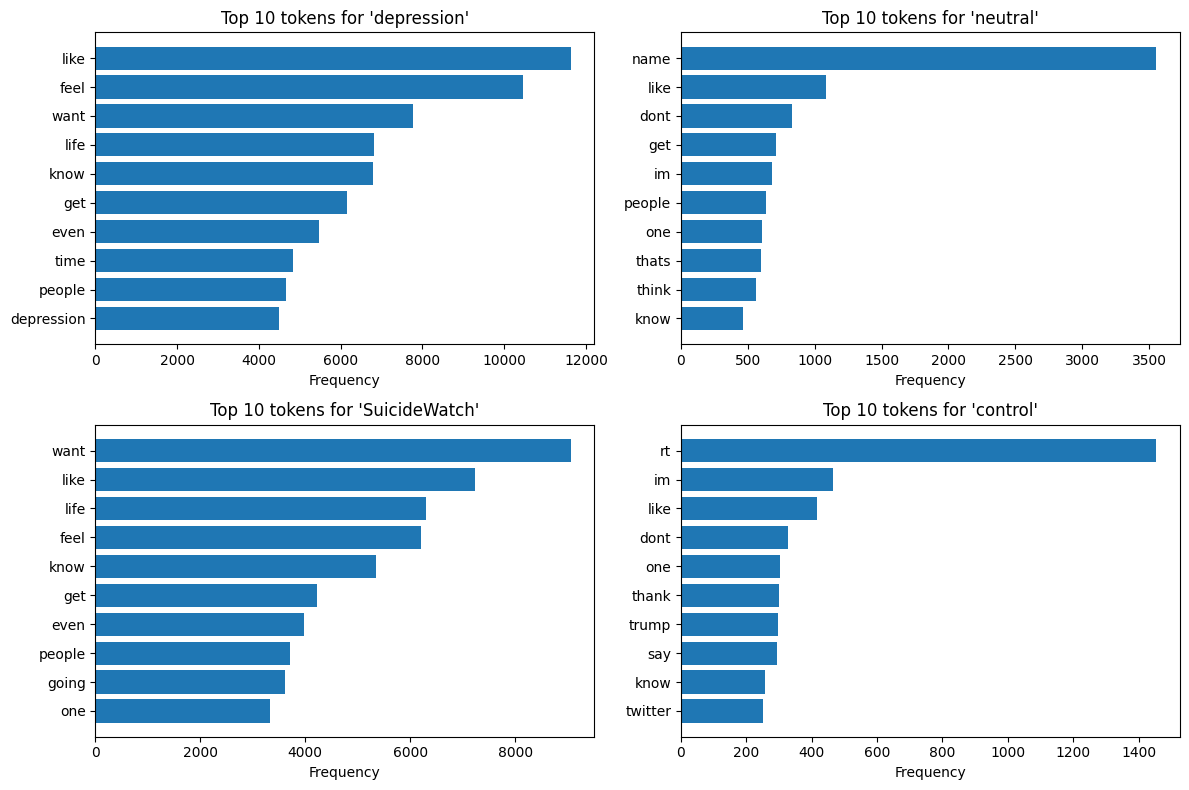

In [11]:
# EDA CELL: Top 10 Tokens per Label (4 panes)
from pyspark.sql.functions import explode, split, lower, regexp_replace, col
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt

# Pick 4 labels to compare
compare_labels = ["depression", "neutral", "SuicideWatch", "control"]

# Tokenize & clean punctuation, lowercase
tokens = (
    df2.select("label","text")
       .withColumn("token",
           explode(
             split(
               lower(regexp_replace(col("text"), "[^\\w\\s]", "")),
               "\\s+"
             )
           )
       )
)

# Remove stopwords & empties
stopwords = StopWordsRemover.loadDefaultStopWords("english")
tokens = tokens.filter(
    (~col("token").isin(stopwords)) &
    (col("token") != "")
)

# Plot top 10 tokens for each label
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, lbl in zip(axes.flatten(), compare_labels):
    top_pd = (
        tokens.filter(col("label") == lbl)
              .groupBy("token").count()
              .orderBy(col("count").desc())
              .limit(10)
              .toPandas()
    )
    ax.barh(top_pd["token"][::-1], top_pd["count"][::-1])
    ax.set_title(f"Top 10 tokens for '{lbl}'")
    ax.set_xlabel("Frequency")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis: Top 5-grams by Label

This section identifies the most common 5-word sequences (5-grams) within selected labels: `depression`, `joy`, `SuicideWatch`, and `nervousness`. Text is tokenized using regular expression-based splitting, and 5-grams are generated from these tokens. The resulting 5-grams are exploded into individual rows and aggregated to determine frequency. The top 10 most frequent 5-grams per label are visualized using horizontal bar charts for comparative analysis across categories.

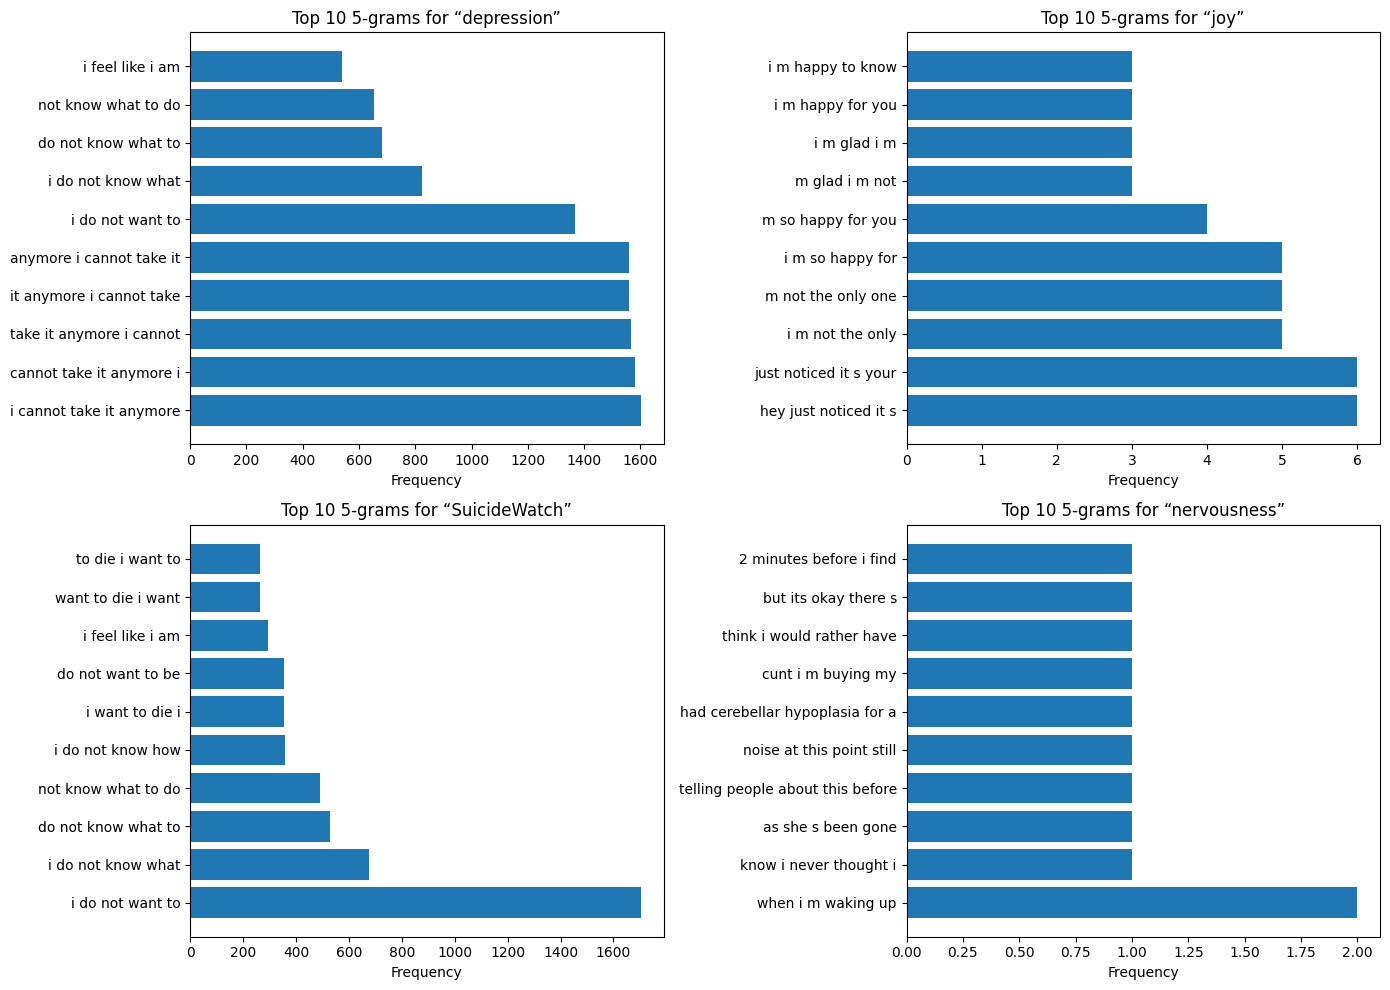

In [12]:
# EDA CELL: Top 10 Five-grams per Label (4 panes)
from pyspark.ml.feature import NGram, RegexTokenizer
from pyspark.sql.functions import explode, col
import matplotlib.pyplot as plt

# Choose labels to compare
compare_labels = ["depression", "joy", "SuicideWatch", "nervousness"]

# Tokenize
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W+")
words_df = tokenizer.transform(df2)

# Create 5-grams
ngram5 = NGram(n=5, inputCol="words", outputCol="ngrams5")
ngrams_df = ngram5.transform(words_df)

# Explode into rows and drop empties
fivegrams = (
    ngrams_df
      .select("label", explode(col("ngrams5")).alias("fivegram"))
      .filter(col("fivegram") != "")
)

# Plot top-10 five-grams for each label
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, lbl in zip(axes.flatten(), compare_labels):
    top10 = (
        fivegrams
          .filter(col("label") == lbl)
          .groupBy("fivegram")
          .count()
          .orderBy(col("count").desc())
          .limit(10)
          .toPandas()
    )
    ax.barh(top10["fivegram"][::-1], top10["count"][::-1])
    ax.set_title(f"Top 10 5-grams for “{lbl}”")
    ax.set_xlabel("Frequency")
    ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Train–Test Split

The balanced dataset is randomly split into training and testing subsets using an 80/20 ratio. A fixed random seed ensures reproducibility of the split. The sizes of the resulting training and test sets are printed for verification.

In [13]:
# Train/Test Split

# Split into 80% train / 20% test
train_df, test_df = df_sampled.randomSplit([0.8, 0.2], seed=42)

# Print out the counts
print("Training rows:", train_df.count())
print("Test rows:    ", test_df.count())

Training rows: 62202
Test rows:     15677


### Naive Bayes Classification Pipeline

A text classification pipeline is constructed using PySpark ML components:

- **Tokenization**: Converts raw text into individual word tokens using a regular expression-based tokenizer.
- **Stopword Removal**: Eliminates common stopwords to reduce noise in the data.
- **Feature Extraction**: Applies the HashingTF and IDF transformations to convert tokens into numerical feature vectors.
- **Label Indexing**: Converts categorical labels into numerical indices for supervised learning.
- **Model Training**: Fits a multinomial Naive Bayes classifier on the training data.

The trained model is then used to make predictions on the test set. Performance is evaluated using standard classification metrics: accuracy, precision, recall, and F1 score.

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the pipeline stages
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W+")
remover   = StopWordsRemover(inputCol="words", outputCol="filtered")
hashTF    = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf       = IDF(inputCol="rawFeatures", outputCol="features")
indexer   = StringIndexer(inputCol="label", outputCol="labelIndex", handleInvalid="skip")
nb        = NaiveBayes(featuresCol="features", labelCol="labelIndex", modelType="multinomial")

pipeline = Pipeline(stages=[tokenizer, remover, hashTF, idf, indexer, nb])

# Train the model
model_nb = pipeline.fit(train_df)

# Predict on the test set
preds_nb = model_nb.transform(test_df)

# Evaluate
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction"
)
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    score = evaluator.setMetricName(metric).evaluate(preds_nb)
    print(f"{metric}: {score:.4f}")

accuracy: 0.2494


weightedPrecision: 0.3750


weightedRecall: 0.2494


f1: 0.2844


### Hyperparameter Tuning with Cross-Validation

To improve model performance, hyperparameter tuning is conducted using a cross-validated grid search:

- A pipeline is defined with tokenization, stopword removal, TF-IDF feature extraction, label indexing, and Naive Bayes classification.
- A parameter grid is created to explore different values for the number of features in the HashingTF transformation and the smoothing parameter in Naive Bayes.
- A 3-fold cross-validation procedure is used to evaluate model performance, with F1 score as the optimization metric.
- The best model is selected based on average cross-validated F1 score and is evaluated on the held-out test set.

The selected hyperparameters and the corresponding test F1 score are printed for analysis.

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes

# Re-define the tokenizer, remover, hashingTF, idf, indexer, and NB stages
tokenizer = RegexTokenizer(inputCol="text",    outputCol="words",    pattern="\\W+")
remover   = StopWordsRemover(inputCol="words", outputCol="filtered")
hashTF    = HashingTF(inputCol="filtered",    outputCol="rawFeatures")
idf       = IDF(inputCol="rawFeatures",       outputCol="features")
indexer   = StringIndexer(inputCol="label",   outputCol="labelIndex", handleInvalid="skip")
nb        = NaiveBayes(featuresCol="features", labelCol="labelIndex", modelType="multinomial")

pipeline_nb = Pipeline(stages=[tokenizer, remover, hashTF, idf, indexer, nb])

# Build the parameter grid
paramGrid = (ParamGridBuilder()
    .addGrid(hashTF.numFeatures,    [500, 1000, 2000])
    .addGrid(nb.smoothing,          [0.5, 1.0, 1.5])
    .build()
)

# Evaluator (we’ll optimize for F1)
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="f1"
)

# 3-fold cross-validator
cv = CrossValidator(
    estimator=pipeline_nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

# Fit CV on the training split
cvModel = cv.fit(train_df)

# Evaluate the best model on the test split
bestModel = cvModel.bestModel
preds_cv = bestModel.transform(test_df)
bestF1  = evaluator.evaluate(preds_cv)
print(f"Test F1 of best model: {bestF1:.4f}")

# Inspect best hyperparameters
print("Best numFeatures:", bestModel.stages[2].getNumFeatures())
print("Best smoothing:  ", bestModel.stages[-1].getSmoothing())

Test F1 of best model: 0.3068
Best numFeatures: 2000
Best smoothing:   1.5


### Detailed Classification Report

A detailed classification report is generated to assess the performance of the final model across all predicted classes. Predictions from the best pipeline model are converted to a pandas DataFrame for compatibility with scikit-learn’s `classification_report`. 

The report includes precision, recall, F1-score, and support for each label. To ensure meaningful interpretation, labels with minimal support (≤ 1 instance) are excluded from the summary. The final metrics are displayed in the original label order for consistency.

In [16]:
# CLEANED‐UP EVAL CELL (DROP support=1)
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display

# Grab your trained pipeline & StringIndexerModel
best_pipeline = cvModel.bestModel        # or model_nb
indexer_model = best_pipeline.stages[4]  # adjust if your indexer is elsewhere
emotion_labels = indexer_model.labels

# Predict
preds = best_pipeline.transform(test_df)

# To pandas
pdf = preds.select("labelIndex","prediction").toPandas().astype(int)
y_true, y_pred = pdf["labelIndex"], pdf["prediction"]

# Build full report dict
report_dict = classification_report(
    y_true, y_pred,
    labels=list(range(len(emotion_labels))),
    target_names=emotion_labels,
    zero_division=0,
    output_dict=True
)

# Into DataFrame & drop tiny‐support rows
report_df = pd.DataFrame(report_dict).T
report_df = report_df[report_df["support"] > 1]

# Reorder to original label order
report_df = report_df.loc[[lbl for lbl in emotion_labels if lbl in report_df.index]]

# Show only the four metrics
display(report_df[["precision","recall","f1-score","support"]].round(3))

,precision,recall,f1-score,support
depression,0.498,0.332,0.398,1694.0
neutral,0.282,0.051,0.086,1678.0
SuicideWatch,0.609,0.708,0.655,1669.0
control,0.800,0.546,0.649,1661.0
admiration,0.409,0.275,0.329,968.0
approval,0.214,0.092,0.128,885.0
annoyance,0.118,0.059,0.079,610.0
amusement,0.425,0.450,0.437,518.0
gratitude,0.493,0.570,0.529,525.0
disapproval,0.146,0.104,0.121,491.0


### Model Export

The best cross-validated Naive Bayes pipeline model is saved to disk for future use. This allows the trained model to be reloaded later without the need for retraining, supporting deployment or continued experimentation.

In [ ]:
# Save the best cross‐validated NB pipeline model
model_path = "models/nb_best_model"
bestModel.write().overwrite().save(model_path)
print(f"Model saved to {model_path}")

Model saved to /kaggle/working/nb_best_model


### Model Inference on Custom Inputs

This section demonstrates how to load a previously saved Naive Bayes pipeline model and apply it to new, user-defined text inputs. The preprocessing stages (tokenization, stopword removal, TF, and IDF transformations) are manually reapplied to ensure consistency with training.

After generating predictions, the predicted label and its associated confidence score are extracted and displayed. This approach is useful for validating model behavior on specific phrases or testing deployment readiness.

In [ ]:
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col, element_at, udf
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import StringType

# Load saved NB pipeline
loaded_nb = PipelineModel.load("models/nb_best_model")

# Extract the fitted transformers & models
tokenizer    = loaded_nb.stages[0]
remover      = loaded_nb.stages[1]
hashTF       = loaded_nb.stages[2]
idfModel     = loaded_nb.stages[3]
indexerModel = loaded_nb.stages[4]
nbModel      = loaded_nb.stages[5]

# Rebuild an idx→label UDF from StringIndexerModel
labels = indexerModel.labels
idx2label = udf(lambda i: labels[i], StringType())

# Defining custom prompts here
my_prompts = [
    "I am anxious",
    "I don't lose hope",
    "This is so beautiful"
]

# Turning them into a DataFrame
input_df = spark.createDataFrame([(t,) for t in my_prompts], ["text"])

# Manually applying the preprocessing stages
tmp = input_df
for stage in [tokenizer, remover, hashTF, idfModel]:
    tmp = stage.transform(tmp)

# Run only the NB model
preds = nbModel.transform(tmp)

# Convert probability vector → array
preds = preds.withColumn("prob_array", vector_to_array("probability"))

# Cast & map to string label + grab the confidence
preds2 = (
    preds
    .withColumn("predIdx", col("prediction").cast("int"))
    .withColumn("predictedLabel", idx2label(col("predIdx")))
    .withColumn("predictedScore", element_at(col("prob_array"), col("predIdx") + 1))
)

# Show just text, predictedLabel, and predictedScore
preds2.select("text", "predictedLabel", "predictedScore").show(truncate=False)

+--------------------+--------------+------------------+
|text                |predictedLabel|predictedScore    |
+--------------------+--------------+------------------+
|I am anxious        |nervousness   |0.9763799547522122|
|I don't lose hope   |optimism      |0.9413867858871718|
|This is so beautiful|admiration    |0.9992727792813064|
+--------------------+--------------+------------------+



### Conclusion

This notebook presented a complete end-to-end pipeline for detecting mental health-related signals from social media text. It included data ingestion, cleaning, exploratory analysis, class balancing, feature extraction, model training using Naive Bayes, hyperparameter tuning with cross-validation, and final model evaluation.

The trained model was also saved and successfully used to generate predictions on custom input data, demonstrating its readiness for inference tasks.